In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import re
import warnings
warnings.filterwarnings('ignore')

def minMaxScale(data, m = None): #min max scaling
    mini = min(data)
    maxi = max(data)
    
    if (m != None): mini = m
    
    return (data - mini)/(maxi - mini)

In [2]:
#importing our clean data
data = pd.read_csv('../data/data.csv', index_col = 0)
data_profit = pd.read_csv('../data/profit_data.csv', index_col = 0)

In [3]:
print(len(data), len(data_profit))
display(data.sample(), data_profit.sample()) #samples of our data with and without budgets

78684 49058


,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,box_office_adj
68917,Ben Youcef,M,1979-02-19,Brüno,2009.0,138805831.0,81.0,5.9,149548,"[' ""Comedy""}']","[' ""United States of America""}']",1.559616e+08


,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,budget,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,profit,profit_adj
5661,Peter Ustinov,M,1921-04-16,Death on the Nile,7920000,1978.0,14560084.0,140.0,7.36,182635,"[' ""Crime Fiction""', ' ""Thriller""', ' ""Detecti...","[' ""United Kingdom""}']",6640084.0,2.459290e+07


In [4]:
worst_profit = min(data_profit['profit_adj']) 
#worst movie
data_profit.query(f'profit_adj == {worst_profit}').sample()

,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,budget,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,profit,profit_adj
364,Merian C. Cooper,M,1893-10-24,King Kong,207000000,1933.0,1856000.0,100.0,7.178571,543198,"[' ""Monster movie""', ' ""Horror""', ' ""Adventure...","[' ""United States of America""}']",-205144000.0,-4.102880e+09


Here, we can see there are issues with the matching of movies & budgets. It is matching the budget for the 2005 King Kong movie to the 1933 King Kong movie, we will remove these outliers of data matching errors will for further movie success analysis.

In [5]:
#After some research seeing that the largest movie losses aren't over 100 million
movies_profit = data_profit.drop_duplicates(subset = 'Movie_name')
len(movies_profit.query(f'profit_adj <= -100000000'))
#59 movies that lost more than 100 million dollars, we can presume that these are mismatched movies in the budgets
#and there are maybe more than 59

59

In [6]:
print('actor data without the budget ', len(data.drop_duplicates(subset = 'Actor_name')), 'actor data with the budget',  
      len(data_profit.drop_duplicates(subset = 'Actor_name'))) 
print('movie data without the budget ', len(data.drop_duplicates(subset = 'Movie_name')), 'movie data with the budget',  
      len(data_profit.drop_duplicates(subset = 'Movie_name'))) 

actor data without the budget  21924 actor data with the budget 15502
movie data without the budget  7361 movie data with the budget 3610


Because of the mismatched budget data and hard drop off in data points of actors & movies we have decided to calculate for the P2 milestone the star score of our actors without taking into account the budget but we will be using it for further regression analysis.

## Observation of distributions

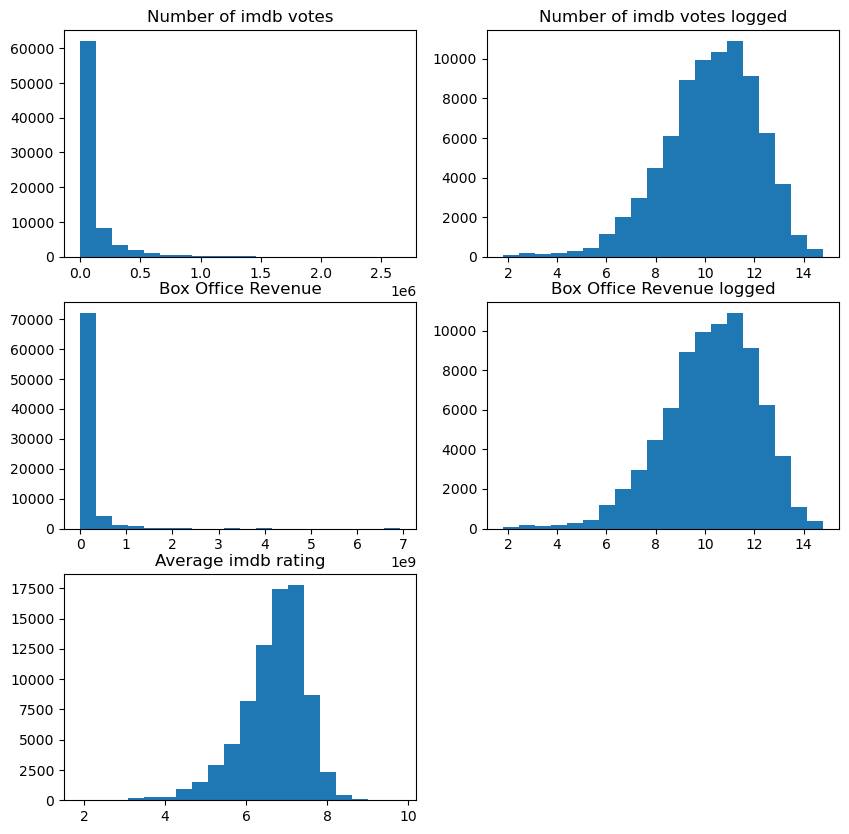

In [7]:
#observation of distributions
fig, ax = plt.subplots(3, 2, figsize=(10, 10)) #sharey=True)

titles = ['Number of imdb votes', 'Box Office Revenue']
for idx, feature in enumerate(['numVotes', 'box_office_adj']):
    ax[idx, 0].hist(data[feature], bins = 20)
    ax[idx, 0].set_title(titles[idx])
    ax[idx, 1].hist(np.log(data['numVotes']), bins = 20)
    ax[idx, 1].set_title(titles[idx] + ' logged')
    
ax[2, 0].hist(data['averageRating'], bins = 20)
ax[2, 0].set_title('Average imdb rating')
ax[2, 1].remove()

plt.show()

# Star score calculation

first we need to deflate the imdb ratings by the amount of votes they've gotten

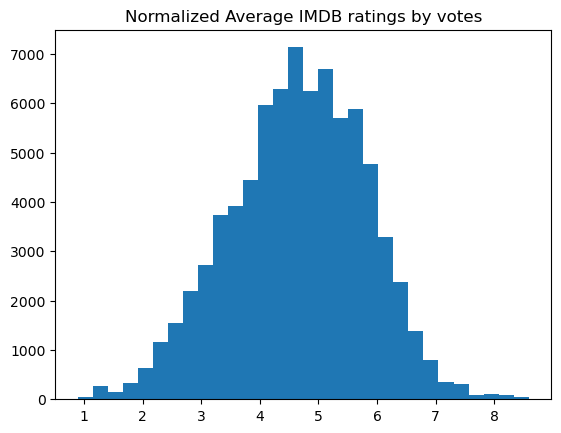

In [8]:
data['numVotes_factor'] = minMaxScale(np.log(data['numVotes']), m = 0)
data['averageRating_adj'] =  data['averageRating']* data['numVotes_factor']
plt.hist(data['averageRating_adj'], bins = 30) #adjusted to the number of votes
plt.title("Normalized Average IMDB ratings by votes")
plt.show()

## Normality tests of our logged box office & our imdb grade dataset
To see if our distributions are log)-normal and normal.

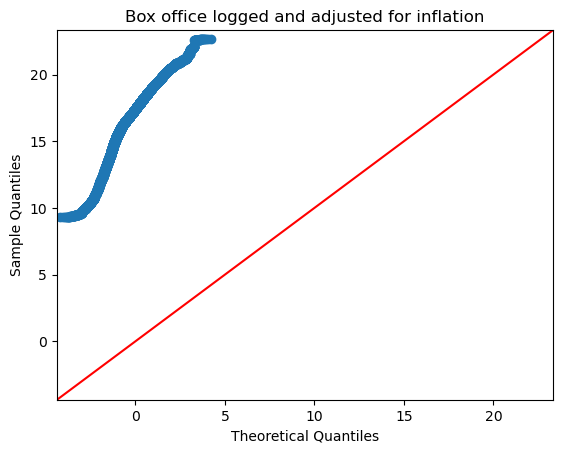

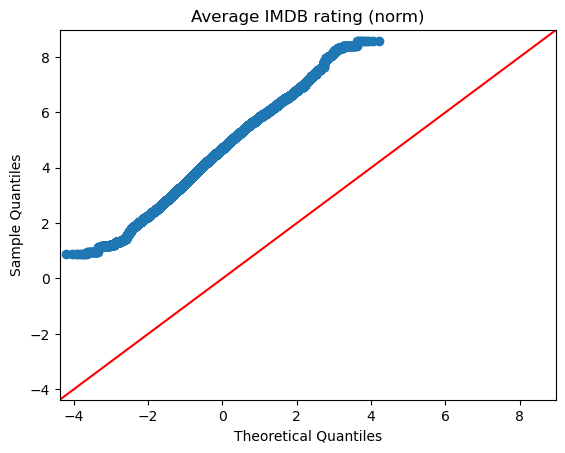

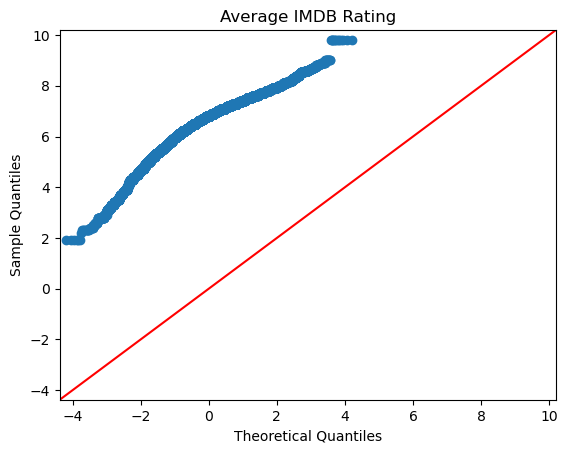

In [9]:
#QQ plots of the distributions to assess how much our logged and adjusted for votes imdb grades match a normal dist

data['box_office_adj_log'] = np.log(data['box_office_adj'])
factors = ['box_office_adj_log', 'averageRating_adj', 'averageRating']
titles = ['Box office logged and adjusted for inflation', 'Average IMDB rating (norm)', 'Average IMDB Rating']
for idx, factor in enumerate(factors): 
    sm.qqplot(data[factor], line='45')
    plt.title(titles[idx])
    
plt.show()

In [10]:
from scipy.stats import kstest #Kolmogorov–Smirnov test of normality

for factor in factors: 
    print(factor + ' normality = ', kstest(data[factor], 'norm')) 

box_office_adj_log normality =  KstestResult(statistic=1.0, pvalue=0.0)
averageRating_adj normality =  KstestResult(statistic=0.9672104945753547, pvalue=0.0)
averageRating normality =  KstestResult(statistic=0.9976979450558071, pvalue=0.0)


We can see that despite our plotted observations our box office data is not log-normal
and our average imdb grades aswell as our adjusted grades are not normally distributed (p value < 0, we can reject the null hypothesis that says they are normal).

#### Star scores to the latest date of the dataset 
This is for the P2 milestone, we will do longitudinal (temporal) star scores for P3

In [11]:
data['actor'] = data["Actor_name"].apply(lambda x : '_'.join(x.split())) #simplifying actor names
star_scores = pd.DataFrame(data['actor'].drop_duplicates().reset_index(drop = True)) #creation of starscore dataf

In [13]:
for idx, actor in enumerate(star_scores['actor']):
    
    ds = data[data['actor'] == actor] #dataframe of all the actor's movies
    star_scores.loc[idx, 'rev_sum'] = ds['box_office_adj'].sum() #sum of the box offices of the actor's movies 
    star_scores.loc[idx, 'grade_sum'] = ds['averageRating_adj'].sum() #sum of the adjusted grades of the movies
    star_scores.loc[idx, 'appearances'] = len(ds) #total movies per actor

In [14]:
#log product = sum of log, we are using this because we have 2 very heavy tailed distributions
star_scores['score'] = np.log(star_scores['rev_sum'] * star_scores['grade_sum']) 
star_scores['score_epfl'] = (minMaxScale(star_scores['score']) * 5) + 1 #min max scaled to epfl standards
star_scores.head(3)

,actor,rev_sum,grade_sum,appearances,score,score_epfl
0,Dustin_Farnum,6.117500e+06,2.861536,1.0,16.678023,2.697314
1,Elmer_Clifton,1.250000e+09,4.791714,1.0,22.513298,4.217113
2,Robert_Harron,1.250000e+09,4.791714,1.0,22.513298,4.217113


In [15]:
len(star_scores.query('appearances == 1'))/len(star_scores) #48% of actors have 1 movie

0.4836708629812078

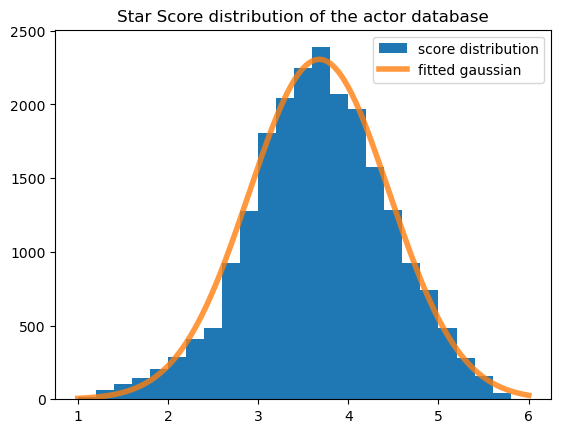

In [16]:
skew, loc, std = stats.skewnorm.fit(star_scores['score_epfl'])
rv = stats.skewnorm(skew ,loc ,std)
x = np.linspace(1,6, 500)
plt.hist(star_scores['score_epfl'], bins = 25, label = 'score distribution')
plt.title("Star Score distribution of the actor database")
plt.plot(x, 4500*rv.pdf(x), lw=4,  alpha = 0.8, label = 'fitted gaussian')
plt.legend()
plt.show()

In [17]:
top_actors = star_scores.sort_values(by = 'score_epfl', ascending = False).reset_index(drop = True)
top_actors.head(20) #Top 20 actors by their star score

,actor,rev_sum,grade_sum,appearances,score,score_epfl
0,Samuel_L._Jackson,1.598184e+10,352.123247,69.0,29.358700,6.000000
1,Frank_Welker,1.465697e+10,306.403368,60.0,29.133084,5.941238
2,Tom_Hanks,1.336099e+10,257.706172,46.0,28.867425,5.872047
3,Bruce_Willis,1.003699e+10,308.937981,60.0,28.762683,5.844767
4,Robin_Williams,1.028146e+10,266.290526,52.0,28.638196,5.812345
5,Eddie_Murphy,1.223664e+10,195.184415,44.0,28.501646,5.776780
6,Morgan_Freeman,9.160455e+09,247.529101,48.0,28.449690,5.763248
7,Robert_De_Niro,7.231283e+09,310.554290,58.0,28.440041,5.760735
8,Nicolas_Cage,6.751959e+09,298.582841,59.0,28.332146,5.732634
9,Liam_Neeson,8.091377e+09,246.450570,48.0,28.321226,5.729790


,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,box_office_adj,numVotes_factor,averageRating_adj,box_office_adj_log,actor
11574,Maggie Smith,F,1934-12-28,Murder by Death,1976.0,32511047.0,94.0,7.300000,38482,"[' ""Parody""', ' ""Thriller""', ' ""Detective fict...","[' ""United States of America""}']",1.354627e+08,0.713682,5.209877,18.724207,Maggie_Smith
11760,Sigourney Weaver,F,1949-10-08,Annie Hall,1977.0,38251425.0,94.0,8.000000,266022,"[' ""Romantic comedy""', ' ""Comedy of manners""',...","[' ""United States of America""}']",1.530057e+08,0.844372,6.754979,18.845986,Sigourney_Weaver
13129,Drew Barrymore,F,1975-02-22,Altered States,1980.0,19853892.0,104.0,7.475000,36023,"[' ""Science Fiction""', ' ""Horror""', ' ""Surreal...","[' ""United States of America""}']",5.839380e+07,0.709218,5.301406,17.882720,Drew_Barrymore
18668,Kathy Bates,F,1948-06-28,The Morning After,1986.0,25147055.0,103.0,7.094828,15273,"[' ""Thriller""', ' ""Mystery""', ' ""Psychological...","[' ""United States of America""}']",5.466751e+07,0.651215,4.620262,17.816780,Kathy_Bates
21967,Julia Roberts,F,1967-10-28,Mystic Pizza,1988.0,12793213.0,105.0,6.300000,29812,"[' ""Romantic comedy""', ' ""Ensemble Film""', ' ""...","[' ""United States of America""}']",2.610860e+07,0.696426,4.387482,17.077775,Julia_Roberts
30518,Cameron Diaz,F,1972-08-30,The Mask,1994.0,351583407.0,101.0,7.115000,405195,"[' ""Crime Fiction""', ' ""Romance Film""', ' ""Act...","[' ""United States of America""}']",5.670700e+08,0.872816,6.210088,20.155993,Cameron_Diaz


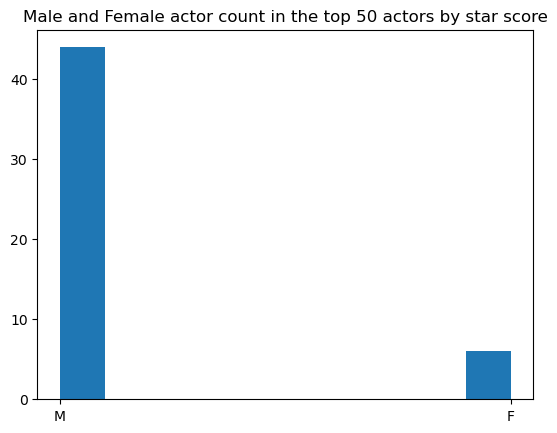

In [18]:
top_actor_data = data[data['actor'].isin(top_actors['actor'].head(50))].drop_duplicates(subset = 'actor')
plt.hist(top_actor_data['Actor_gender']) 
plt.title('Male and Female actor count in the top 50 actors by star score')
top_actor_data.query('Actor_gender == "F"') #Female actors in the top 50 actors

In [49]:
genders = data[['Actor_gender', 'actor']].drop_duplicates(subset='actor')
star_scores['gender'] = star_scores.merge(genders, left_on = 'actor', 
                                          right_on = 'actor', how = 'inner')['Actor_gender']
star_scores.sample()

,actor,rev_sum,grade_sum,appearances,score,score_epfl,gender,cluster
2714,Douglass_Watson,3.028988e+08,9.064703,2.0,21.733297,4.013962,M,1


# New Part

Actors with high-salaries usually play with other actors with high-salaries, that necessarily play in movies with high-budget and history repeats itself (which is also systematically correlated with our "experience" definition). To tackle this possible confounder, the identification of *sub-classes* of actors in the dataset can be carried out. This would allow us to differentiate the analysis to comparable groups of actors in terms of our parameters of interest, namely revenues, movie ratings and number of appearances.

The formula for the star score is given below.

$star\ score = log\left(\sum_{movie=1}^{n}revenue_i \cdot \sum_{movie=1}^{n}(ratings_{normalized}){_i}\right)$

To be noted that the star scored is defined on the 'career' of the actor, namely it is increased at each appearance in a movie (cumulative sum).

In [50]:
#log because it's strongly skewed
X = star_scores[{'rev_sum','grade_sum','appearances'}].apply('log')

In [51]:
#standardize before clustering
X['rev_sum'] = (X['rev_sum'] - X['rev_sum'].mean())/X['rev_sum'].std()
X['grade_sum'] = (X['grade_sum'] - X['grade_sum'].mean())/X['grade_sum'].std()
X['appearances'] = (X['appearances'] - X['appearances'].mean())/X['appearances'].std()

In [52]:
#clustering with DBSCAN (different shapes)
from sklearn.cluster import DBSCAN
eps = 0.58

labels = DBSCAN(eps=eps).fit_predict(X)

In [53]:
#dimensionality reduction with PCA
from sklearn.decomposition import PCA

X_reduced_pca = PCA(n_components=2).fit_transform(X)

In [54]:
#dimensionality reduction with t-SNE
from sklearn.manifold import TSNE

X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(X)

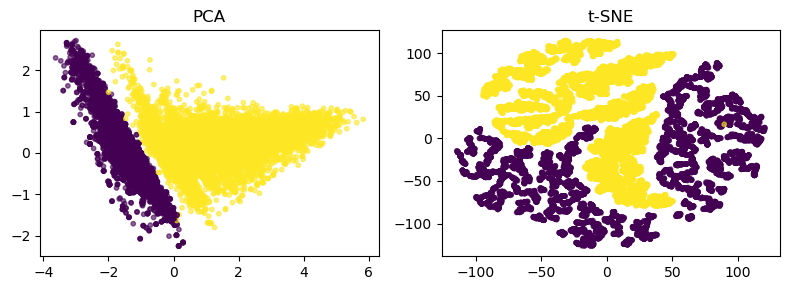

In [55]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

sbplt = ax[0]
sbplt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1],c=labels, alpha=0.6, s=10)
sbplt.set_title("PCA")

sbplt = ax[1]
sbplt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6, s=10)
sbplt.set_title("t-SNE")
    
fig.tight_layout()
plt.show()

In [56]:
#add clustered label to dataset
star_scores['cluster'] = labels

In [57]:
#split dataset into clusters
k1 = star_scores[star_scores['cluster'] == 1]
k2 = star_scores[star_scores['cluster'] == 0]

In [58]:
#analysis of the clusters
print('Average number of appearances ' + 'k1: ' + str(k1.appearances.mean()) 
      + ' k2: ' + str(k2.appearances.mean()))
print('Average grade that his/her movies received ' + 'k1: ' + str((k1.grade_sum/k1.appearances).mean()) 
      + ' k2: ' + str((k2.grade_sum/k2.appearances).mean()))
print('Average revenue that his/her movies received ' + 'k1: ' + str((k1.rev_sum/k1.appearances).mean()/1e6) + ' M$' 
      + ' k2: ' + str((k2.rev_sum/k2.appearances).mean()/1e6) + ' M$')

print('The number of actors in the first cluster is: ' + str(len(k1)))
print('The number of actors in the second cluster is: ' + str(len(k2)))

Average number of appearances k1: 6.014134275618375 k2: 1.0
Average grade that his/her movies received k1: 4.599464794423057 k2: 4.564781036275039
Average revenue that his/her movies received k1: 116.00546499010878 M$ k2: 107.38650295702246 M$
The number of actors in the first cluster is: 11320
The number of actors in the second cluster is: 10604


By analyzing the two clusters, it is clear how the two classes of actors are mainly separated by number of appearances. Indeed, almost half of the actors (**10604** out of 21924) have only made one movie appearance. This directly impacts our formulation of the star score, given that to account for the popularity of an actor on the score, the **sum** of the revenues and the **sum** of the ratings have been considered, and **NOT the average**. Indeed, if the average would have been considered, actors starring in only one movie would have similar scores to actors starring in multiple movies with comparable average of revenues and ratings. To put more weight on the 'experience', the sum is believed to be a more significant mathematical operator.

The formula of the star score is shown again below.


$star\ score = log\left(\sum_{movie=1}^{n}revenue_i \cdot \sum_{movie=1}^{n}(ratings_{normalized}){_i}\right)$

To conclude, the number of appearances is intrinsically present in the formula, due to the presence of the sum.

The latter is proved by plotting the distribution of the star scores for the two clusters of actors. Even if the average revenue and rating for the clusters were comparable, the star scores are higher for the clustered actors with larger appearances.

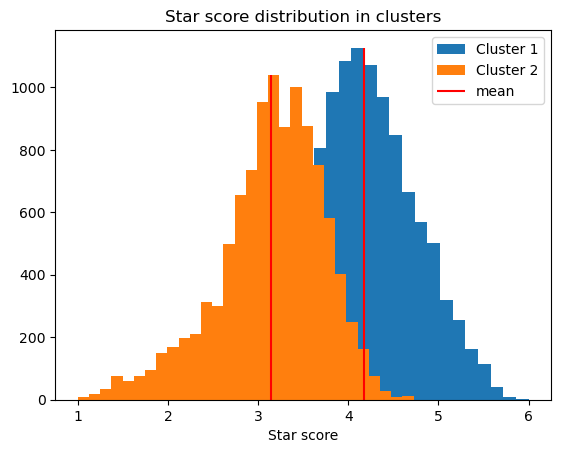

In [59]:
plt.hist(k1.score_epfl, bins=30, label='Cluster 1')
plt.hist(k2.score_epfl, bins=30, label='Cluster 2')
plt.vlines(np.mean(k1.score_epfl),ymin=0,ymax=1125,color='r', label='mean')
plt.vlines(np.mean(k2.score_epfl),ymin=0,ymax=1040,color='r')
plt.title('Star score distribution in clusters')
plt.xlabel('Star score')
plt.legend()
plt.show()

From now on, the analysis will be carried out in parallel on the two sub-classes of actors defined by the clusters. This could help us quantify the impact of actors on movies with different approaches.

- The impact of *popular* actors on movies (cluster 1, appearances > 1);
- The impact of *unknown* actors on the movie (cluster 2, appearances = 1).

To capture the influence of the different parameters on the star score, a regression analysis is carried out. This allows to have a sense of the different weights brought by the revenues, the ratings and the number of appearances on the output. As explained previously, the number of appearances is intrinsically correlated with the sum of the revenues, therefore, it should not be included in the predictors.

In [76]:
#keep parameters of interest (#apply log on predictors because strongly skewed distribution)
#cluster 1
X1 = k1[{'rev_sum','grade_sum','score_epfl','gender'}]
X1['rev_sum'] = X1['rev_sum'].apply('log')
X1['grade_sum'] = X1['grade_sum'].apply('log')

#cluster 2
X2 = k2[{'rev_sum','grade_sum','score_epfl','gender'}] #appearances always equal to 1 in cluster 2 (not considered in the predictors)
X2['rev_sum'] = X2['rev_sum'].apply('log')
X2['grade_sum'] = X2['grade_sum'].apply('log')

In [77]:
#standardization of predictors
#cluster 1
X1['rev_sum'] = (X1['rev_sum'] - X1['rev_sum'].mean())/X1['rev_sum'].std()
X1['grade_sum'] = (X1['grade_sum'] - X1['grade_sum'].mean())/X1['grade_sum'].std()

#cluster 2
X2['rev_sum'] = (X2['rev_sum'] - X2['rev_sum'].mean())/X2['rev_sum'].std()
X2['grade_sum'] = (X2['grade_sum'] - X2['grade_sum'].mean())/X2['grade_sum'].std()

The results of the regression for the two clusters are shown below. It is worth mentioning that the explained variance *R-squared* is equal to one because the star score is defined as linear combination of the predictors in the **logarithmic domain**.

The average star scores are **4.18** and **3.14** for clusters 1 and 2, respectively. The influence of the revenues is larger than the influence of the ratings for both clusters, even if it is stronger in the second one (*Crev1*=**0.41**, *Crev2*=**0.55**). On the contrary, the influence of the ratings on the score is larger in the first cluster (*Crat1*=**0.21**, *Crat2*=**0.08**).

In [78]:
import statsmodels.formula.api as smf #for linear and logistic regression

mod1 = smf.ols(formula='score_epfl ~ rev_sum + grade_sum',
              data=X1)
res1 = mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:             score_epfl   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.143e+33
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:12:24   Log-Likelihood:             3.7561e+05
No. Observations:               11320   AIC:                        -7.512e+05
Df Residuals:                   11317   BIC:                        -7.512e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1784   8.84e-18   4.73e+17      0.0

In [79]:
import statsmodels.formula.api as smf #for linear and logistic regression

mod2 = smf.ols(formula='score_epfl ~ rev_sum + grade_sum',
              data=X2)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:             score_epfl   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.078e+33
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:12:24   Log-Likelihood:             3.5191e+05
No. Observations:               10604   AIC:                        -7.038e+05
Df Residuals:                   10601   BIC:                        -7.038e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1432   9.09e-18   3.46e+17      0.0

### Gender bias analysis

After having defined the star score in detail and having explicitely calculated the weights of the different parameters on the output numerical value, it would be interesting to carry out a gender study to identify if there are any gender biases in the choice of actors for successful movies. 

A fair assumption here is that high budget movies will be movies with greater revenues and better ratings. PROVE IT HERE!!! (CORRELATION BETWEEN BUDGETS AND REVENUES,RATINGS).

We aim to do that by taking advantage of supervised machine learning techniques. After splitting the dataset into training and testing dataset, we train a logistic regression classifier to argue if it easier to distinguish an actor or an actress based on the success of the movies he/she starred in (defined by the revenues, ratings and appearances, namely the *star scores*). To reach this goal, only the most successful movies must be considered. The threshold is imposed on the star score; if the star score is larger or equal than **5**, it is assumed that the actor has starred in a sufficiently high number of successful movies.

Given that the first cluster already groups the most successfull actors, it is the only one considered for the gender study.

In [80]:
#filter out least-successful movies
X1 = X1[X1['score_epfl'] >= 5]

In [81]:
#convert gender categorical variable into binary variable
X1['gender'] = (X1['gender'] == 'M').astype('int')

In [82]:
#split dataset into training and testing
from sklearn.model_selection import train_test_split

train, test = train_test_split(X1, test_size=0.2)#cluster 1

In [83]:
#separate predictors and labels
#cluster 1
Xtrain = train[{'rev_sum','grade_sum'}]
ytrain = train['gender']

Xtest = test[{'rev_sum','grade_sum'}]
ytest = test['gender']

In [84]:
#implement logistic regression model
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs') #create model
log_reg.fit(Xtrain, ytrain) # train it
ypred = log_reg.predict(Xtest)

In [85]:
#compute precision of the model
from sklearn.metrics import precision_score

print('The precision of the model is ' + str(precision_score(ytest,ypred)))

The precision of the model is 0.7461139896373057


This result implies that the logistic regression classifier assigns with higher probability males to successful movies. A result different than a precision of 0.5 (with some margin) implies a gender bias in the choice of the actors.

Are movies more successfull because of this gender distribution in the cast or are higher budget movies (higher success) more prone to hire actors with this gender distribution?

### Genre bias

Recalling that the final purpose of the project is developing a predictive model to predict the success of a future movie based on the presence of an actor, a further feature to be analyzed more deeply are the genres. Indeed, a potential confounder to be considered is that actors may have more success in specific movie categories rather than others. This problem is tackled by the development of a k-means clustering model that clusters each actor into one genre by using the success of the movies they starred in as predictor (revenues, ratings and appearances). This would allow us to attribute to each actor the genre that caused him to have the most success in the movies he starred in and it would narrow down the list of actors to be selected for a future movie depending on the genre of such.

In [ ]:
#k-means clustering to cluster genres
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=n_clusters, random_state=42) #create model
kmean.fit_predict(X) #no y (unsupervised) #train